In [698]:
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import NearestNeighbors


%matplotlib inline
# その他設定
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-darkgrid')
font = fm.FontProperties(fname='./TakaoPGothic.ttf')

# 読み込み

In [654]:
dataset_url = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'
df = pd.read_csv(dataset_url)
df.shape

(10000, 35)

In [655]:
df

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0
5,0,0,0,1,0,0,24.5,0,0,0,1,0,0,0,0,0,0,103.0,3.3,0,0,0,0,1,0,0,1,0,0,0,0,0,48.417899,0,0
6,0,0,0,0,0,1,19.0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,53.426757,0,0
7,0,0,0,0,1,0,54.5,0,1,1,0,0,0,0,0,0,0,449.5,4.0,1,0,0,0,0,0,0,0,0,1,0,0,0,56.697458,0,0
8,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,61.996340,0,0
9,0,0,0,1,0,0,34.5,1,0,1,0,0,0,0,0,0,0,449.5,6.5,1,0,0,0,0,0,0,0,0,0,1,0,0,64.557893,0,0


In [656]:
df.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

# EDA

今回は、「CM施策後のゲームの利用時間」であるgamesecondを目的変数とする。  
また、CMを見たかの割り当てはcm_dummyである。  
詳細は、岩波データサイエンスvol3を参照。

In [657]:
df['gamesecond'].describe()

count     10000.000000
mean       2846.783400
std       17973.608991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


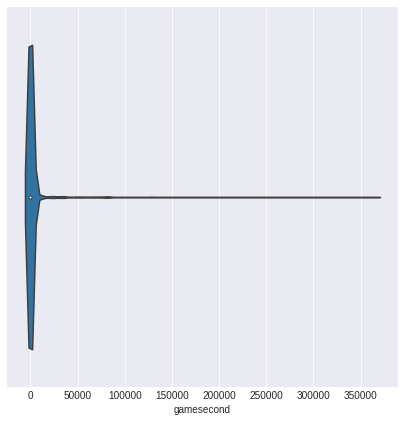

In [658]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax = sns.violinplot(x=df["gamesecond"])
fig.show()

## 割り当てとyの関係の可視化

単純に集計すると、割り当てなしの方が効果があるという結果になる。

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


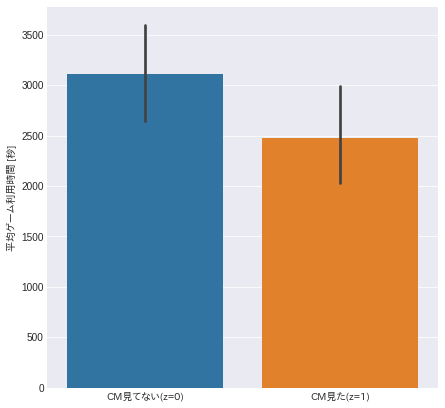

In [659]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(x='cm_dummy', y='gamesecond', data=df, ax=ax)
ax.set_xticklabels(['CM見てない(z=0)', 'CM見た(z=1)'], fontproperties=font)
ax.set_xlabel('')
ax.set_ylabel('平均ゲーム利用時間 [秒]', fontproperties=font)
fig.show()

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


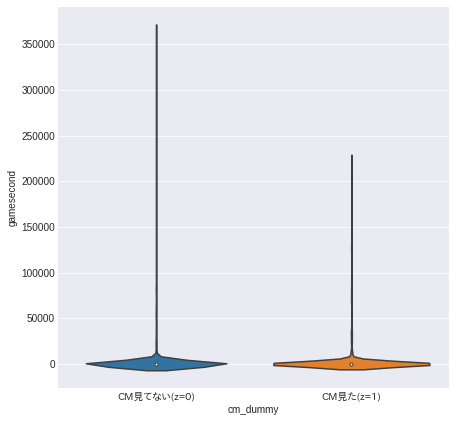

In [660]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax = sns.violinplot(x='cm_dummy', y='gamesecond', data=df, ax=ax)
ax.set_xticklabels(['CM見てない(z=0)', 'CM見た(z=1)'], fontproperties=font)
fig.show()

In [661]:
for z in (0, 1):
    df_tmp = df[df['cm_dummy'] == z]
    print(z, df_tmp['gamesecond'].describe())

0 count      5856.000000
mean       3107.706455
std       19496.771900
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64
1 count      4144.000000
mean       2478.065878
std       15564.015196
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      223096.000000
Name: gamesecond, dtype: float64


# 傾向スコアモデリング

$P(z|x)$を求める  。  
モデルは別になんでも良い。  
一応、CVを切る。  
パラメータチューニングは省略。

In [662]:
z_col = 'cm_dummy'
x_cols = [
    col for col in df.columns
    if col not in ['gamecount', 'gamedummy', 'gamesecond', 'cm_dummy']
]
df_x = df[x_cols]
df_z = df[z_col]
df_x.shape, df_z.shape

((10000, 31), (10000,))

## 各種モデルの学習

### 学習

In [663]:
oof_preds_lgb = np.zeros(df.shape[0])
oof_preds_lr = np.zeros(df.shape[0])
oof_preds_rf = np.zeros(df.shape[0])
insample_logloss_list_lgb = []
insample_logloss_list_lr = []
insample_logloss_list_rf= []
feature_importance_df = pd.DataFrame()

kf = KFold(n_splits=5, shuffle=True, random_state=0)
for n_fold, (train_index, valid_index) in enumerate(kf.split(df_x)):
    print('CV_{}'.format(n_fold))
    X_train, z_train = df_x.values[train_index], df_z.values[train_index]
    X_valid, z_valid = df_x.values[valid_index], df_z.values[valid_index]
    lgb_train = lgb.Dataset(X_train, label=z_train, free_raw_data=False)
    lgb_test = lgb.Dataset(X_valid, label=z_valid, free_raw_data=False)

    # LightGBM
    print('LightGBM_fitting...')
    params = {
        'task': 'train',
        'objective': 'binary',
        'metric': 'binary',
    }
    model_lgb = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test'],
        num_boost_round=100000,
        early_stopping_rounds=100,
        verbose_eval=1000)
    # LogisticRegression
    print('LogisticRegression_fitting...')
    model_lr = LogisticRegression()
    model_lr.fit(X_train, z_train)
    
    #RF
    print('RandomForestClassifier_fitting...')
    model_rf =  RandomForestClassifier(n_estimators=500)
    model_rf.fit(X_train, z_train)
    
    # pred_for_insample
    pred_insample_lgb =  model_lgb.predict(X_train, num_iteration=model_lgb.best_iteration)
    pred_insample_lr =   model_lr.predict_proba(X_train)[:, 1]
    pred_insample_rf =   model_rf.predict_proba(X_train)[:, 1]
    insample_logloss_lgb = (log_loss(z_train, pred_insample_lgb))
    insample_logloss_lr = (log_loss(z_train, pred_insample_lr))
    insample_logloss_rf = (log_loss(z_train, pred_insample_rf))
    print('insample_logloss_of_LightGBM:{}'.format(insample_logloss_lgb))
    print('insample_logloss_of_LogisticRegression:{}'.format(insample_logloss_lr))
    print('insample_logloss_of_RandomForestClassifier:{}'.format(insample_logloss_rf))
    insample_logloss_list_lgb.append(insample_logloss_lgb)
    insample_logloss_list_lr.append(insample_logloss_lr)
    insample_logloss_list_rf.append(insample_logloss_rf)


    # pred_for_oof
    oof_pred_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    oof_pred_lr = model_lr.predict_proba(X_valid)[:, 1]
    oof_pred_rf = model_rf.predict_proba(X_valid)[:, 1]
    oof_preds_lgb[valid_index] = oof_pred_lgb
    oof_preds_lr[valid_index] = oof_pred_lr
    oof_preds_rf[valid_index] = oof_pred_rf
    oof_logloss_lgb = (log_loss(z_valid, oof_pred_lgb))
    oof_logloss_lr = (log_loss(z_valid, oof_pred_lr))
    oof_logloss_rf = (log_loss(z_valid,oof_pred_rf))
    print('oof_logloss_of_LightGBM:{}'.format(oof_logloss_lgb))
    print('oof_logloss_of_LogisticRegression:{}'.format(oof_logloss_lr))
    print('oof_logloss_of_RandomForestClassifier:{}'.format(oof_logloss_rf))


    # 重要度の算出
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = x_cols
    fold_importance_df["importance"] = np.log1p(
        model_lgb.feature_importance(
        importance_type='gain', iteration=model_lgb.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0)
    
print('all_CV_done')
print('CV_insample_logloss_of_LightGBM:{}'.format(np.mean(insample_logloss_list_lgb)))
print('CV_insample_logloss_of_LogisticRegression:{}'.format(np.mean(insample_logloss_list_lr)))
print('CV_insample_logloss_of_RandomForestClassifier:{}'.format(np.mean(insample_logloss_list_rf)))
print('CV_oof_logloss_of_LightGBM:{}'.format(log_loss(df_z, oof_preds_lgb)))
print('CV_oof_logloss_of_LogisticRegression:{}'.format(log_loss(df_z, oof_preds_lr)))
print('CV_oof_logloss_of_RandomForestClassifier:{}'.format(log_loss(df_z, oof_preds_rf)))

#予測値をdfに追加
df['pred_lgb'] = oof_preds_lgb
df['pred_lr'] = oof_preds_lr
df['pred_rf'] = oof_preds_rf

CV_0
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds.
[1000]	train's binary_logloss: 0.0020966	test's binary_logloss: 0.00112411
[2000]	train's binary_logloss: 0.0017459	test's binary_logloss: 0.000740716
[3000]	train's binary_logloss: 0.00174453	test's binary_logloss: 0.000739135
[4000]	train's binary_logloss: 0.00174416	test's binary_logloss: 0.000738706
[5000]	train's binary_logloss: 0.00174398	test's binary_logloss: 0.000738489
[6000]	train's binary_logloss: 0.00174386	test's binary_logloss: 0.000738344
[7000]	train's binary_logloss: 0.00174379	test's binary_logloss: 0.000738246
[8000]	train's binary_logloss: 0.00174372	test's binary_logloss: 0.000738174
[9000]	train's binary_logloss: 0.00174368	test's binary_logloss: 0.000738123
[10000]	train's binary_logloss: 0.00174364	test's binary_logloss: 0.000738082
[11000]	train's binary_logloss: 0.00174361	test's binary_logloss: 0.000738044
[12000]	train's binary_logloss: 0.00174359	test's binary_logloss: 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


insample_logloss_of_LightGBM:0.0017435655035548817
insample_logloss_of_LogisticRegression:0.5392044156301812
insample_logloss_of_RandomForestClassifier:0.0017102617249761679
oof_logloss_of_LightGBM:0.0007379782724517561
oof_logloss_of_LogisticRegression:0.5378723802047685
oof_logloss_of_RandomForestClassifier:0.00436050038923308
CV_1
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds.
[1000]	train's binary_logloss: 0.00206823	test's binary_logloss: 0.00213911
[2000]	train's binary_logloss: 0.00177098	test's binary_logloss: 0.00177546
[3000]	train's binary_logloss: 0.00176968	test's binary_logloss: 0.00177383
[4000]	train's binary_logloss: 0.00176933	test's binary_logloss: 0.00177341
[5000]	train's binary_logloss: 0.00176915	test's binary_logloss: 0.00177319
[6000]	train's binary_logloss: 0.00176904	test's binary_logloss: 0.00177306
[7000]	train's binary_logloss: 0.00176896	test's binary_logloss: 0.00177295
[8000]	train's binary_logloss: 0.00176891	test's 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


insample_logloss_of_LightGBM:0.0017688485542038323
insample_logloss_of_LogisticRegression:0.5431429907993707
insample_logloss_of_RandomForestClassifier:0.0017351489343561148
oof_logloss_of_LightGBM:0.0017727986958037212
oof_logloss_of_LogisticRegression:0.5434957028392358
oof_logloss_of_RandomForestClassifier:0.004304096638276791
CV_2
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds.
[1000]	train's binary_logloss: 0.00183086	test's binary_logloss: 0.00478074
Early stopping, best iteration is:
[1024]	train's binary_logloss: 0.00176967	test's binary_logloss: 0.00470663
LogisticRegression_fitting...


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomForestClassifier_fitting...
insample_logloss_of_LightGBM:0.0017696682537251443
insample_logloss_of_LogisticRegression:0.5357155924442081
insample_logloss_of_RandomForestClassifier:0.0017155324253132858
oof_logloss_of_LightGBM:0.004706627256950975
oof_logloss_of_LogisticRegression:0.5509982601838586
oof_logloss_of_RandomForestClassifier:0.004868761875333856
CV_3
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds.
[1000]	train's binary_logloss: 0.00224514	test's binary_logloss: 0.00769373
Early stopping, best iteration is:
[1002]	train's binary_logloss: 0.00223685	test's binary_logloss: 0.00759138
LogisticRegression_fitting...
RandomForestClassifier_fitting...


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


insample_logloss_of_LightGBM:0.0022368460812801365
insample_logloss_of_LogisticRegression:0.5402696650610179
insample_logloss_of_RandomForestClassifier:0.0015778264353765205
oof_logloss_of_LightGBM:0.007591384994069606
oof_logloss_of_LogisticRegression:0.5343974034517758
oof_logloss_of_RandomForestClassifier:0.004089269278637753
CV_4
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds.
[1000]	train's binary_logloss: 0.00111677	test's binary_logloss: 0.0017933
Early stopping, best iteration is:
[1243]	train's binary_logloss: 0.000822785	test's binary_logloss: 0.00154536
LogisticRegression_fitting...
RandomForestClassifier_fitting...


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


insample_logloss_of_LightGBM:0.0008227848239439595
insample_logloss_of_LogisticRegression:0.5399540565031865
insample_logloss_of_RandomForestClassifier:0.0018634746933409497
oof_logloss_of_LightGBM:0.001545355103061579
oof_logloss_of_LogisticRegression:0.5439383749620381
oof_logloss_of_RandomForestClassifier:0.005216201834182216
all_CV_done
CV_insample_logloss_of_LightGBM:0.001668342643341591
CV_insample_logloss_of_LogisticRegression:0.5396573440875929
CV_insample_logloss_of_RandomForestClassifier:0.0017204488426726078
CV_oof_logloss_of_LightGBM:0.003270828864467527
CV_oof_logloss_of_LogisticRegression:0.5421404243283353
CV_oof_logloss_of_RandomForestClassifier:0.004567766003132739


In [664]:
df['cm_dummy'].mean(), df['pred_lgb'].mean(), df['pred_lr'].mean(), df['pred_rf'].mean()

(0.4144, 0.4139583733150712, 0.4153451686903096, 0.4143629999999999)

### importance の可視化

In [665]:
def display_importances(feature_importance_df_, png_path=None):
    cols = feature_importance_df_[[
        "feature", "importance"
    ]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(12, 15))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if png_path is not None:
        plt.savefig(png_path)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


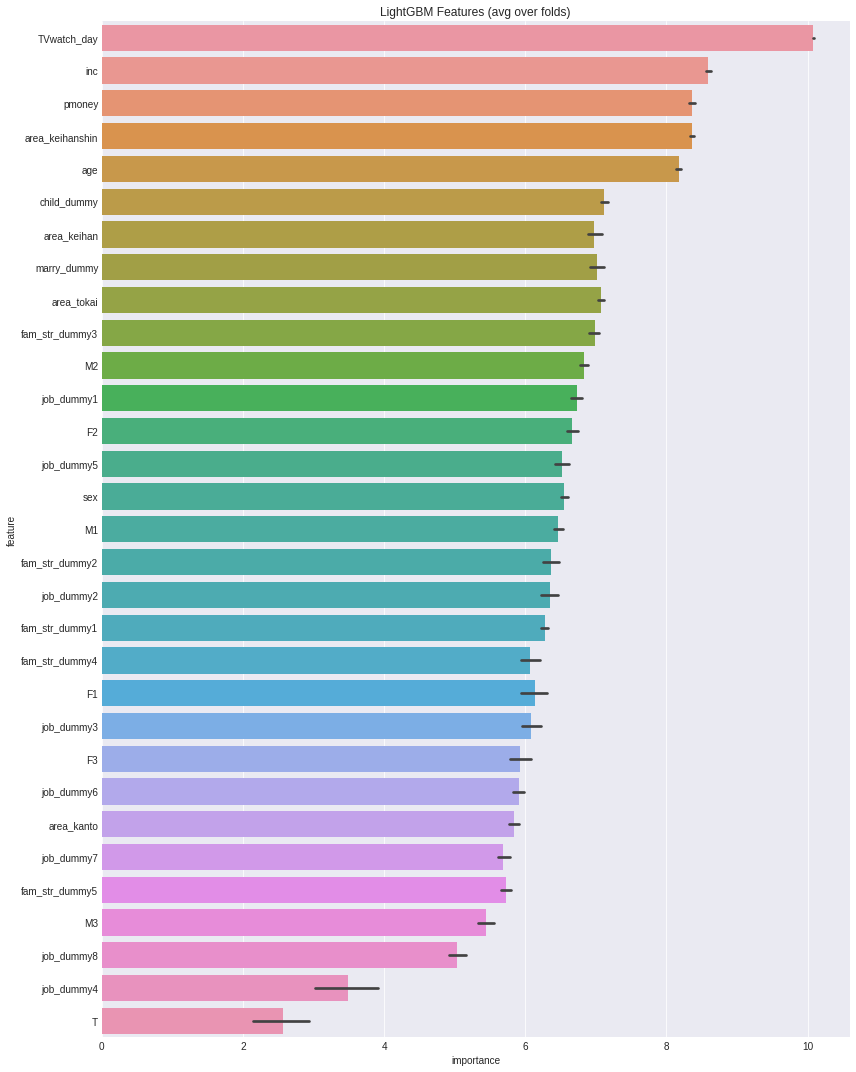

In [666]:
display_importances(feature_importance_df)

## ROC曲線 / AUC(c統計量の算出)

model:lgb_auc:0.999995
model:lr_auc:0.790189
model:rf_auc:1.000000


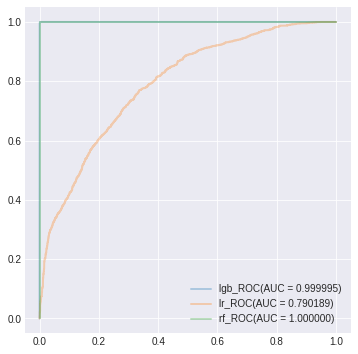

In [667]:
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111, aspect='equal')
for model in ['lgb', 'lr', 'rf']:
    prob = df['pred_{}'.format(model)]
    fpr, tpr, t = roc_curve(df['cm_dummy'], prob)
    roc_auc = auc(fpr, tpr)
    print('model:{}_auc:{:.6f}'.format(model, roc_auc))
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label='{}_ROC(AUC = {:.6f})'.format(model, roc_auc))
ax.legend(prop={'size': 10})
fig.show()

## 傾向スコアの分布の確認

In [668]:
def visualize_ps(model, png_path=None):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(111)
    bins = np.linspace(0, 1, 100)
    ax.hist(
        df[df['cm_dummy'] == 0]['pred_{}'.format(model)],
        bins=bins,
        color='red',
        width=0.01,
        alpha=0.2,
        label='ctr')
    ax.hist(
        df[df['cm_dummy'] == 1]['pred_{}'.format(model)],
        bins=bins,
        color='blue',
        width=0.01,
        alpha=0.2,
        label='test')
    ax.set_xlim(0, 1.0)
    ax.legend(prop={'size': 10})
    ax.set_title('{}_PS'.format(model), fontdict={'fontsize': 10})
    fig.show()
    if png_path is not None:
        fig.savefig(png_path)

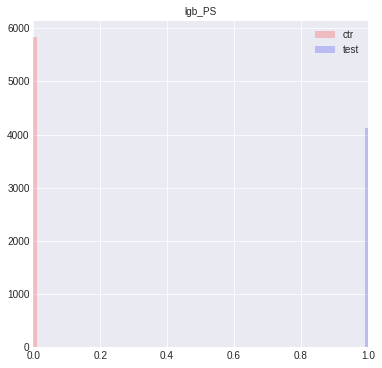

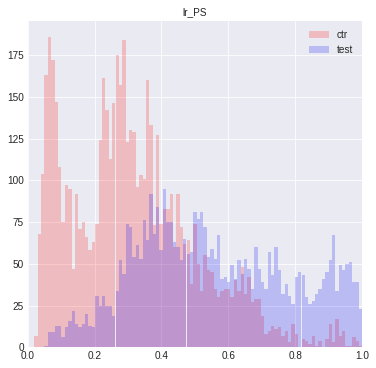

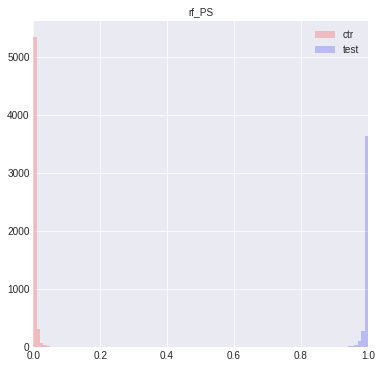

In [669]:
for model in ['lgb', 'lr', 'rf']:
    visualize_ps(model)

## 傾向スコアの逆数で共変量を重み付け

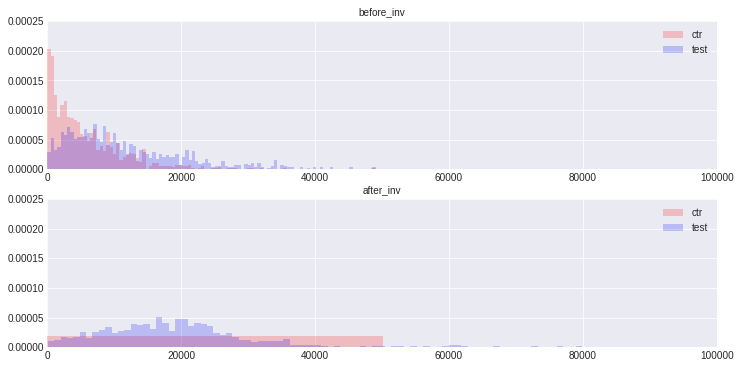

In [824]:
col = 'TVwatch_day'
model = 'lr'
z_col = 'cm_dummy'
ps_col = 'pred_{}'.format(model)

df_test = df.loc[df[z_col] == 1][[col, ps_col]]
df_ctr = df.loc[df[z_col] == 0][[col, ps_col]]
x_test_inv = df_test[col] / df_test[ps_col]
x_ctr_inv = df_ctr[col] / (1 - df_ctr[ps_col])

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(211)
bins = 100
ax.hist(df_ctr[col], bins=bins, color='red', alpha=0.2, label='ctr', density=True)
ax.hist(df_test[col], bins=bins, color='blue', alpha=0.2, label='test', density=True)
ax.legend(prop={'size': 10})
ax.set_title('before_inv', fontdict={'fontsize': 10})
ax.set_xlim(0, 100000)
ax.set_ylim(0, 0.00025)

ax = fig.add_subplot(212)
ax.hist(x_ctr_inv, bins=bins, color='red', alpha=0.2, label='ctr', density=True)
ax.hist(x_test_inv, bins=bins, color='blue', alpha=0.2, label='test', density=True)
ax.legend(prop={'size': 10})
ax.set_title('after_inv', fontdict={'fontsize': 10})
ax.set_xlim(0, 100000)
ax.set_ylim(0, 0.00025)

fig.show()

# 傾向スコアマッチング

## マッチング 

主だったライブラリが見つからなかったので、do whyライブラリを元に改造  
https://github.com/microsoft/dowhy/blob/91d175b9fc8f61af28dfccdeda2556acdc977ff2/dowhy/causal_estimators/propensity_score_matching_estimator.py

In [792]:
def ps_matching(df, y_col, z_col, ps_col, caliper=None):
    treated = df.loc[df[z_col] == 1]
    control = df.loc[df[z_col] == 0]
    control_neighbors = (NearestNeighbors(
        n_neighbors=1,
        algorithm='ball_tree').fit(control[ps_col].values.reshape(-1, 1)))
    distances, indices = control_neighbors.kneighbors(
        treated[ps_col].values.reshape(-1, 1))
    print('num_of_test_{}'.format(len(treated)))
    if caliper is not None:
        less_caliper_index = np.where(distances.reshape(-1) <= caliper)
        distances = distances[less_caliper_index]
        indices = indices[less_caliper_index]

    # estimate ATE on treated by summing over difference between matched neighbors
    ate = 0
    numtreatedunits = len(indices)
    print('num_of_pair_{}'.format(numtreatedunits))

    df_pair_test =  pd.DataFrame(columns=df.columns)
    df_pair_ctr = pd.DataFrame(columns=df.columns)
    for i in range(numtreatedunits):
        treated_outcome = treated.iloc[i][y_col].item()
        control_outcome = control.iloc[indices[i]][y_col].item()
        ate += treated_outcome - control_outcome
        df_pair_ctr = df_pair_ctr.append(control.iloc[indices[i], :])
        df_pair_test = df_pair_test.append(treated.iloc[i, :])
    ate /= numtreatedunits

    # matchしたテスコンを1行
    df_pair_ctr.reset_index(inplace=True)
    df_pair_test.reset_index(inplace=True)
    df_pair_ctr.columns = ["ctr_" + colname for colname in df_pair_ctr.columns]
    df_pair_test.columns = ["test_" + colname for colname in df_pair_test.columns]

    df_pair = pd.concat([df_pair_test, df_pair_ctr], axis=1)
    print(ate)
    return ate, df_pair

In [793]:
ate, df_pair = ps_matching(df, y_col='gamesecond',  z_col='cm_dummy', ps_col='pred_lr', caliper=0.2)
ate

num_of_test_4144
num_of_pair_4144
271.882722007722


271.882722007722

In [795]:
sum(df_pair['test_gamesecond'] - df_pair['ctr_gamesecond']) / 4144

271.882722007722

## SD

In [814]:
def cal_sd(df_pair, colname):
    x_test = df_pair['test_{}'.format(colname)]
    x_ctr = df_pair['ctr_{}'.format(colname)]
    sd = (np.mean(x_test) - np.mean(x_ctr)) / np.sqrt((np.var(x_test) + np.var(x_ctr)) / 2)
    return abs(sd)

In [818]:
for colname in ['TVwatch_day', 'inc', 'pmoney']:
    sd = cal_sd(df_pair, colname)
    print('SD_of_{}_is:{}'.format(colname, sd))

SD_of_TVwatch_day_is:0.0866092467165027
SD_of_inc_is:0.038831545007124726
SD_of_pmoney_is:0.04211676096041157


# IPW

In [677]:
Y = df['gamesecond']
Z = df['cm_dummy']

PS = df['pred_lr']

IPW1 = sum(Z * Y / PS) / sum(Z / PS)
IPW0 = sum(((1 - Z) * Y) / (1 - PS)) / sum((1 - Z) / (1 - PS))
effect = IPW1 - IPW0
print('IPW_effect:{}'.format(effect))

IPW_effect:469.90583769792784


In [679]:
df_tmp = df[(df['pred_lgb'] < 0.99) & (df['pred_lgb'] > 0.01)]
Y = df_tmp['gamesecond']
Z = df_tmp['cm_dummy']

PS = df_tmp['pred_lgb']

IPW1 = sum(Z * Y / PS) / sum(Z / PS)
IPW0 = sum(((1 - Z) * Y) / (1 - PS)) / sum((1 - Z) / (1 - PS))
effect = IPW1 - IPW0
print('IPW_effect:{}'.format(effect))

IPW_effect:6137.5393988281585


# 回帰分析

In [827]:
y_col = 'gamesecond'
z_col = 'cm_dummy'
x_cols = [
    col for col in df.columns if col not in [
        'gamecount', 'gamecount', 'gamesecond', 'cm_dummy',
        'pred_lgb', 'pred_lr', 'pred_rf',
        'z0_reg_pred_lgb', 'z1_reg_pred_lgb',
        'z0_reg_pred_rf', 'z1_reg_pred_rf',
        'z0_reg_pred_rg', 'z1_reg_pred_rg'
    ]
]
df_x_all = df[x_cols]
df_y_all = df[y_col]
df_x_all.shape, df_y_all.shape

((10000, 32), (10000,))

In [707]:
reg_preds_lgb = np.zeros(df.shape[0])
reg_preds_rf = np.zeros(df.shape[0])
reg_preds_rg = np.zeros(df.shape[0])

for z in [0, 1]:
    print('z={}'.format(z))
    df_tmp = df.loc[df[z_col] == z]
    df_x = df_tmp[x_cols]
    df_y = df_tmp[y_col]
    print(df_x.shape, df_y.shape)

    oof_preds_lgb = np.zeros(df_tmp.shape[0])
    oof_preds_rf = np.zeros(df_tmp.shape[0])
    oof_preds_rg = np.zeros(df_tmp.shape[0])
    insample_mse_list_lgb = []
    insample_mse_list_rf = []
    insample_mse_list_rg = []
    feature_importance_df = pd.DataFrame()
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    for n_fold, (train_index, valid_index) in enumerate(kf.split(df_x)):
        print('CV_{}'.format(n_fold))
        X_train, y_train = df_x.values[train_index], df_y.values[train_index]
        X_valid, y_valid = df_x.values[valid_index], df_y.values[valid_index]
        lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
        lgb_test = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False)

        # LightGBM
        print('LightGBM_fitting...')
        params = {
            'task': 'train',
            'objective': 'regression',
            'metric': 'mse',
        }
        model_lgb = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test'],
            num_boost_round=100000,
            early_stopping_rounds=1000,
            verbose_eval=1000)

        # RF
        print('RandomForestRegressor_fitting...')
        model_rf = RandomForestRegressor(n_estimators=500)
        model_rf.fit(X_train, y_train)

        # Ridge
        print('Ridge_fitting...')
        model_rg = Ridge()
        model_rg.fit(X_train, y_train)

        # pred_for_insample
        pred_insample_lgb = model_lgb.predict( X_train, num_iteration=model_lgb.best_iteration)
        pred_insample_rf = model_rf.predict(X_train)
        pred_insample_rg = model_rg.predict(X_train)

        insample_mse_lgb = (mean_squared_error(y_train, pred_insample_lgb))
        insample_mse_rf = (mean_squared_error(y_train, pred_insample_rf))
        insample_mse_rg = (mean_squared_error(y_train, pred_insample_rg))
        print('insample_mse_of_LightGBM:{}'.format(insample_mse_lgb))
        print('insample_mse_of_RandomForestRegressor:{}'.format(insample_mse_rf))
        print('insample_mse_of_Ridge:{}'.format(insample_mse_rg))
        insample_mse_list_lgb.append(insample_mse_lgb)
        insample_mse_list_rf.append(insample_mse_rf)
        insample_mse_list_rg.append(insample_mse_rg)

        # pred_for_oof
        oof_pred_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
        oof_pred_rf = model_rf.predict(X_valid)
        oof_pred_rg = model_rg.predict(X_valid)
    
        oof_preds_lgb[valid_index] = oof_pred_lgb
        oof_preds_rf[valid_index] = oof_pred_rf
        oof_preds_rg[valid_index] = oof_pred_rg
        
        oof_mse_lgb = (mean_squared_error(y_valid, oof_pred_lgb))
        oof_mse_rf = (mean_squared_error(y_valid, oof_pred_rf))
        oof_mse_rg = (mean_squared_error(y_valid, oof_pred_rg))
        print('oof_mse_of_LightGBM:{}'.format(oof_mse_lgb))
        print('oof_mse_of_RandomForestRegressor:{}'.format(oof_mse_rf))
        print('oof_mse_of_Ridge:{}'.format(oof_mse_rg))

        #全データへの予測値
        reg_preds_lgb += model_lgb.predict(df_x_all.values, num_iteration=model_lgb.best_iteration)
        reg_preds_rf += model_rf.predict(df_x_all.values)
        reg_preds_rg += model_rg.predict(df_x_all.values)

        # 重要度の算出
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = x_cols
        fold_importance_df["importance"] = np.log1p(
            model_lgb.feature_importance(
                importance_type='gain', iteration=model_lgb.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0)

    print('z={}_all_CV_done'.format(z))
    print('CV_insample_mse_of_LightGBM:{}'.format(np.mean(insample_mse_list_lgb)))
    print('CV_insample_mse_of_RandomForestRegressor:{}'.format(np.mean(insample_mse_list_rf)))
    print('CV_insample_mse_of_Ridge:{}'.format(np.mean(insample_mse_list_rg)))
    
    print('CV_oof_mse_of_LightGBM:{}'.format(mean_squared_error(df_y, oof_preds_lgb)))
    print('CV_oof_mse_of_RandomForestRegressor:{}'.format(mean_squared_error(df_y, oof_preds_rf)))
    print('CV_oof_mse_of_Ridge:{}'.format(mean_squared_error(df_y, oof_preds_rg)))
    #予測値をdfに追加
    df['z{}_reg_pred_lgb'.format(z)] = reg_preds_lgb / n_splits
    df['z{}_reg_pred_rf'.format(z)] = reg_preds_rf / n_splits
    df['z{}_reg_pred_rg'.format(z)] = reg_preds_rg / n_splits

z=0
(5856, 31) (5856,)
CV_0
LightGBM_fitting...
Training until validation scores don't improve for 1000 rounds.
[1000]	train's l2: 112707	test's l2: 104353
[2000]	train's l2: 14318.4	test's l2: 25849.5
[3000]	train's l2: 3954.25	test's l2: 18746.4
[4000]	train's l2: 1976.17	test's l2: 17414.5
[5000]	train's l2: 1507.24	test's l2: 17107.1
[6000]	train's l2: 1389.69	test's l2: 17101.8
Early stopping, best iteration is:
[5166]	train's l2: 1476.33	test's l2: 17065.3
RandomForestRegressor_fitting...
Ridge_fitting...
insample_mse_of_LightGBM:1476.327158955872
insample_mse_of_RandomForestRegressor:3460533.679087929
insample_mse_of_Ridge:367641072.24186
oof_mse_of_LightGBM:17065.31485760139
oof_mse_of_RandomForestRegressor:6608707.172368728
oof_mse_of_Ridge:371965150.50188303
CV_1
LightGBM_fitting...
Training until validation scores don't improve for 1000 rounds.
[1000]	train's l2: 135257	test's l2: 3.91476e+06
[2000]	train's l2: 15469.4	test's l2: 3.80483e+06
[3000]	train's l2: 4885.84	test's

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


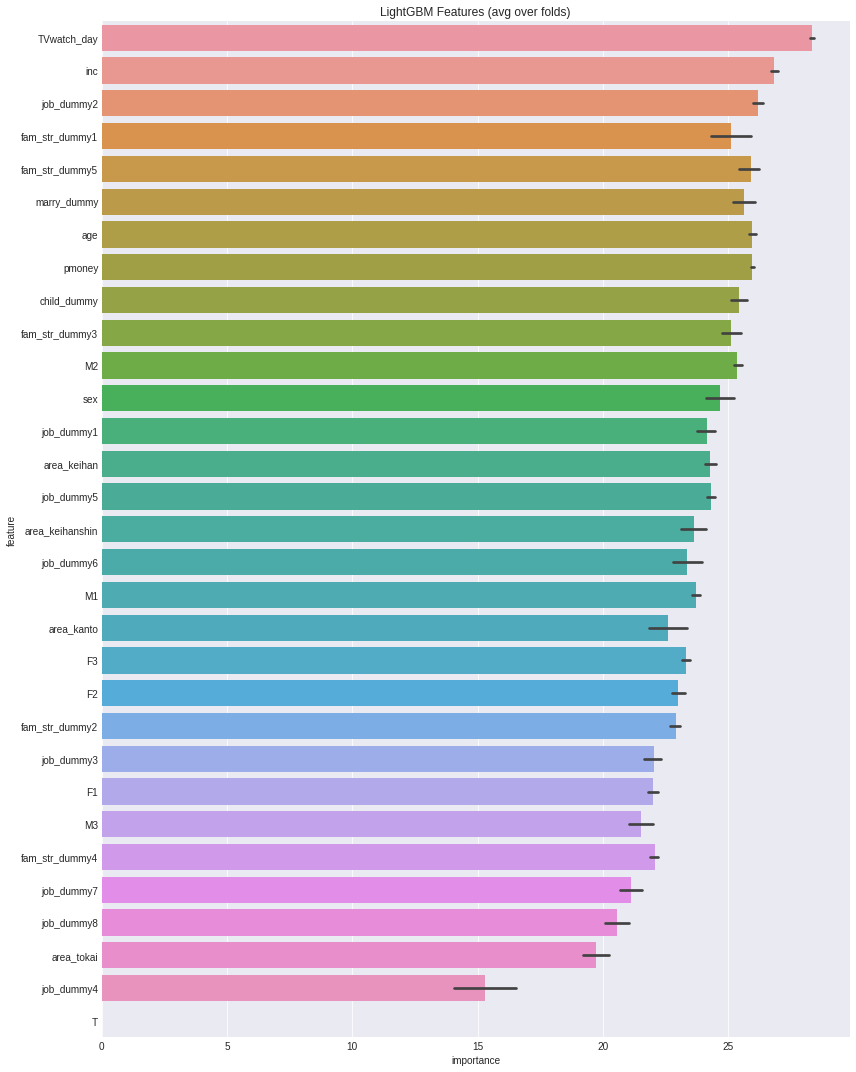

In [709]:
display_importances(feature_importance_df)

# ダブルロバスト

In [723]:
Y = df['gamesecond']
Z = df['cm_dummy']
PS = df['pred_lr']
reg_0 = df['z0_reg_pred_rg']
reg_1 = df['z1_reg_pred_rg']

# E(y_1)
dr_1 = np.mean(Z * Y / PS + (1 - Z / PS) * reg_1)

# E(y_0)
dr_0 = np.mean((1 - Z) * Y / (1 - PS) + (1 - (1 - Z) / (1 - PS)) * reg_0)

print('E(y_1):{}_E(y_0):{}_effect:{}'.format(dr_1, dr_0, dr_1 - dr_0))

E(y_1):3102.2829932265536_E(y_0):2762.315547310952_effect:339.96744591560173


# Priximityマッチング

In [727]:
y_col = 'gamesecond'
z_col = 'cm_dummy'
x_cols = [
    col for col in df.columns if col not in [
        'gamecount', 'gamedummy', 'gamesecond', 'cm_dummy',
        'pred_lgb', 'pred_lr', 'pred_rf',
        'z0_reg_pred_lgb', 'z1_reg_pred_lgb',
        'z0_reg_pred_rf', 'z1_reg_pred_rf',
        'z0_reg_pred_rg', 'z1_reg_pred_rg'
    ]
]
df_x = df[x_cols]
df_z = df[z_col]
df_x.shape, df_z.shape

((10000, 31), (10000,))

In [728]:
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(df_x.values, df_z.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [736]:
def proximity(data):
    prox_matrix = np.zeros((len(data), len(data)))
    n_estimators = len(data[0])

    for e, est in enumerate(np.transpose(np.array(data))):
        print(e)
        for n, n_node in enumerate(est):
            for k, k_node in enumerate(est):
                if n_node == k_node:
                    prox_matrix[n][k] += 1

    prox_matrix = 1.0 * np.array(prox_matrix) / n_estimators

    return prox_matrix

In [732]:
app = model_rf.apply(df_x.values)
app

array([[ 696,  367,   93, ...,  465,  861, 1152],
       [ 908,  576,  111, ..., 1120,  317,  565],
       [1305,   12,   24, ...,  158, 1150,  965],
       ...,
       [ 488,   33,  117, ...,   65, 1290, 1021],
       [ 488,   33,  117, ...,   65, 1290, 1021],
       [ 488,   33,  117, ...,   65, 1290, 1021]])

In [737]:
prox_matrix = proximity(app)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [738]:
prox_matrix.shape

(10000, 10000)

In [742]:
df_prox = pd.DataFrame(prox_matrix)
df_prox.to_pickle('proximity.pkl')

In [819]:
# 対角成分の削除
prox_matrix_remove_diag = prox_matrix - np.diagflat(np.diag(prox_matrix))
# テスト群の行のみ抽出
prox_matrix_remove_diag_test = prox_matrix_remove_diag[df.loc[df[z_col] ==1].index, :]
# コントロール群の列のみ抽出
prox_matrix_remove_diag_test = prox_matrix_remove_diag_test[:, df.loc[df[z_col] == 0].index]
prox_matrix_remove_diag_test.shape
#  各テスト群のデータ(行)に対して最も類似度の高いコントロール群(列)の抽出
max_index = np.argmax(prox_matrix_remove_diag_test, axis=1)

# 　マッチング
df_pair_test = df.loc[df[z_col] == 1]
df_pair_ctr = df.iloc[max_index, :]
df_pair_ctr.reset_index(inplace=True)
df_pair_test.reset_index(inplace=True)
df_pair_ctr.columns = ["ctr_" + colname for colname in df_pair_ctr.columns]
df_pair_test.columns = ["test_" + colname for colname in df_pair_test.columns]
df_pair = pd.concat([df_pair_test, df_pair_ctr], axis=1)
# 因果効果の算出
np.mean(df_pair['test_gamesecond'] - df_pair['ctr_gamesecond']) 

2478.0658783783783

In [820]:
for colname in ['TVwatch_day', 'inc', 'pmoney']:
    sd = cal_sd(df：」：＿＿：_pair, colname)
    print('SD_of_{}_is:{}'.format(colname, sd))

SD_of_TVwatch_day_is:0.7061676939448971
SD_of_inc_is:0.12851003077841508
SD_of_pmoney_is:0.5529597735167537


In [823]:
pred = model_rf.predict_proba(df[x_cols])[:, 1]
log_loss(df[z_col], pred)

0.00038489766249785853

# pdp

In [841]:
from pdpbox import pdp, info_plots

In [873]:
y_col = 'gamesecond'
pdp_x_cols = [
    col for col in df.columns if col not in [
        'gamecount', 'gamesecond', 'pred_lgb',
        'pred_lr', 'pred_rf', 'pred_lgb_calibrated', 
        'z0_reg_pred_lgb', 'z1_reg_pred_lgb',
        'z0_reg_pred_rf', 'z1_reg_pred_rf',
        'z0_reg_pred_rg', 'z1_reg_pred_rg'
    ]
]

In [875]:
# insampleで学習したモデルの作成
lgb_train = lgb.Dataset(df[pdp_x_cols], label=df[y_col], free_raw_data=False)
lgb_test = lgb.Dataset(df[pdp_x_cols], label=df[y_col], free_raw_data=False)

params = {
    'task': 'train',
    'objective': 'regression',
    'metric': 'mse',
}
model_lgb = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    num_boost_round=100000,
    early_stopping_rounds=1000,
    verbose_eval=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	train's l2: 161.4	test's l2: 161.4
[2000]	train's l2: 9.74845	test's l2: 9.74845
[3000]	train's l2: 1.61307	test's l2: 1.61307
[4000]	train's l2: 0.361541	test's l2: 0.361541
[5000]	train's l2: 0.143164	test's l2: 0.143164
[6000]	train's l2: 0.0887365	test's l2: 0.0887365
[7000]	train's l2: 0.0728365	test's l2: 0.0728365
[8000]	train's l2: 0.0676775	test's l2: 0.0676775
[9000]	train's l2: 0.0659213	test's l2: 0.0659213
[10000]	train's l2: 0.0651428	test's l2: 0.0651428
[11000]	train's l2: 0.0648192	test's l2: 0.0648192
[12000]	train's l2: 0.0646842	test's l2: 0.0646842
[13000]	train's l2: 0.064629	test's l2: 0.064629
[14000]	train's l2: 0.0646035	test's l2: 0.0646035
[15000]	train's l2: 0.0645913	test's l2: 0.0645913
[16000]	train's l2: 0.0645862	test's l2: 0.0645862
[17000]	train's l2: 0.0645837	test's l2: 0.0645837
[18000]	train's l2: 0.0645825	test's l2: 0.0645825
[19000]	train's l2: 0.064582	test's l2: 0.064582


https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html

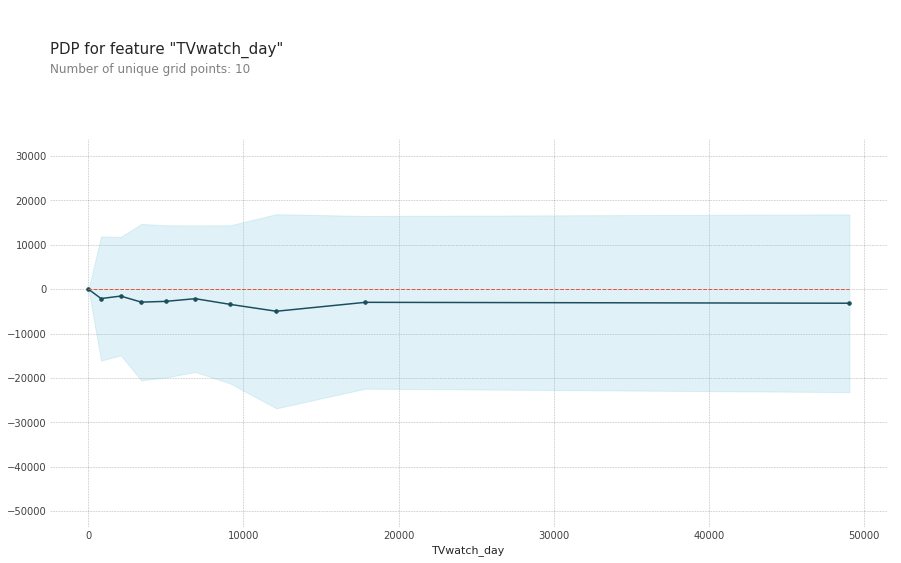

In [876]:
pdp_TV = pdp.pdp_isolate(
    model=model_lgb, dataset=df, model_features=pdp_x_cols, feature='TVwatch_day'
)
fig, axes = pdp.pdp_plot(pdp_TV, 'TVwatch_day',  frac_to_plot=100)

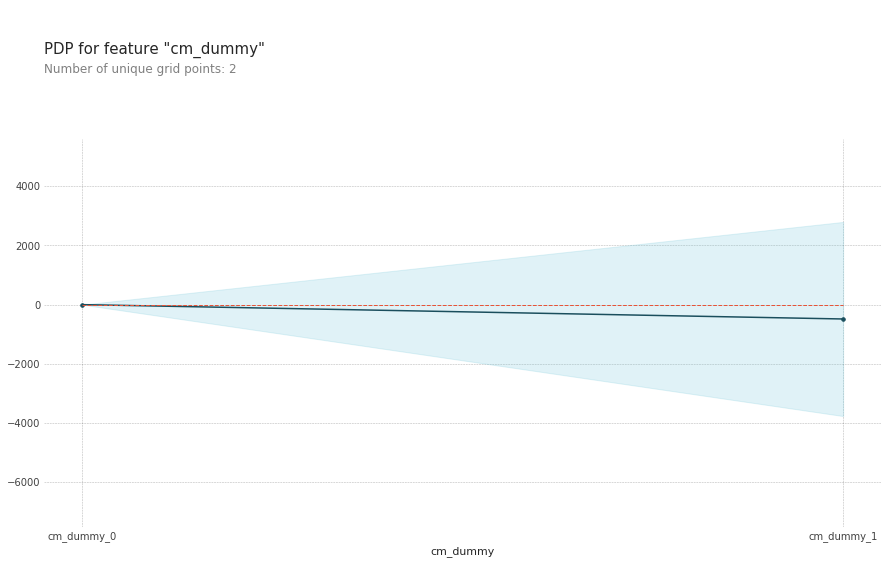

In [878]:
pdp_cm = pdp.pdp_isolate(
    model=model_lgb, dataset=df, model_features=pdp_x_cols, feature='cm_dummy'
)
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_cm,
                         feature_name='cm_dummy',
                         ncols=2)